# Task Description:
- Use the MSELoss Function and compare the result with the NLLLoss Function.
- Try to reduce the overtraining by reducing the size of the network. 

# Implementation:

In [261]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms
import time

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [262]:
# downloading the datasets
cifar10 = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


#### Explore Dataset

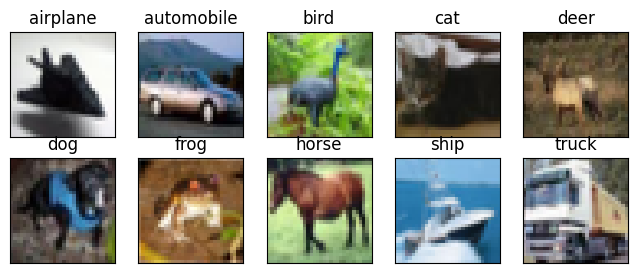

In [263]:
# plot the first image of each class
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

type of dataset: <class 'torchvision.datasets.cifar.CIFAR10'>
Is Instance of class torch.utils.data.Dataset? True
Number of Elements in Dataset: 50000
tensor([[[0.2431, 0.1961,  ..., 0.7176, 0.5373],
         [0.2471, 0.2157,  ..., 0.6706, 0.5686],
         ...,
         [0.7176, 0.5882,  ..., 0.5294, 0.5608],
         [0.8196, 0.7137,  ..., 0.5098, 0.6627]],

        [[0.2510, 0.1961,  ..., 0.7216, 0.5333],
         [0.2549, 0.2078,  ..., 0.6824, 0.5725],
         ...,
         [0.5725, 0.4627,  ..., 0.4627, 0.4902],
         [0.6824, 0.5922,  ..., 0.4667, 0.6118]],

        [[0.1725, 0.1020,  ..., 0.2980, 0.2824],
         [0.1451, 0.1020,  ..., 0.2941, 0.3020],
         ...,
         [0.4588, 0.3725,  ..., 0.3843, 0.4314],
         [0.5647, 0.4824,  ..., 0.4353, 0.6275]]])
automobile


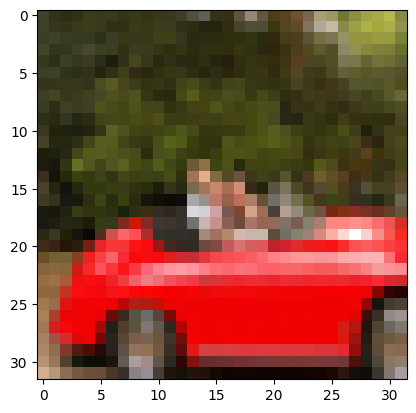

In [264]:
print("type of dataset:",type(cifar10))
print("Is Instance of class torch.utils.data.Dataset?",isinstance(cifar10, torch.utils.data.Dataset))
print("Number of Elements in Dataset:",len(cifar10))

# look at the 99th image in the dataset
img, label = cifar10[99]
print(img)
print(class_names[label])
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [265]:
imgs = torch.stack([img for img, _ in cifar10], dim=3)
print("Shape of Images:",imgs.shape)
print("Mean of Images:",imgs.view(3, -1).mean(dim=1))
print("Standard Deviation of Images:", imgs.view(3, -1).std(dim=1))

Shape of Images: torch.Size([3, 32, 32, 50000])
Mean of Images: tensor([0.4914, 0.4822, 0.4465])
Standard Deviation of Images: tensor([0.2470, 0.2435, 0.2616])


#### Normalize Dataset

In [266]:
cifar10 = datasets.CIFAR10('data', train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))

cifar10_val = datasets.CIFAR10('data', train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


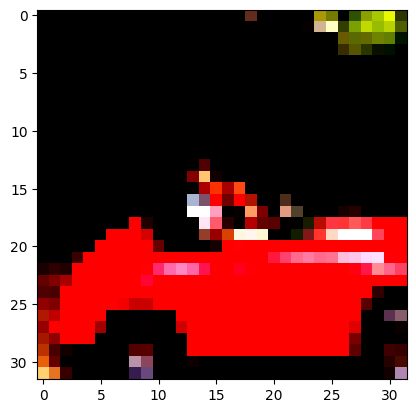

In [267]:
# look at normalized image
img, label = cifar10[99]
print(class_names[label])
plt.imshow(img.permute(1, 2, 0))
plt.show()

#### Reduce dataset

In [268]:
# two new datasets are created from the original CIFAR-10 dataset, 
# considering only images and labels from classes 0 and 2
label_map = {0: 0, 2: 1}
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

#### Define Model and Training Loop

In [269]:
# generates the probability distributions over different classes and stores them for each element individually in a vector
# the sum of all elements in the vector is 1.
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [277]:
def accuracy_calculator(modelOrNeurons, dataset):
    correct = 0
    total = 0
    if type(modelOrNeurons) == int:
        num_neurons = modelOrNeurons
        model = nn.Sequential(
            nn.Linear(3072, num_neurons),
            nn.Tanh(),
            nn.Linear(num_neurons, 2),
            nn.LogSoftmax(dim=1))
    else:
        model = modelOrNeurons
    with torch.no_grad():
        for img, label in dataset:
            out = model(img.view(img.shape[0], -1))
            _, predicted = torch.max(out, dim=1)
            total += label.shape[0]
            correct += int((predicted == label).sum())
    accuracy = (correct / total)         
    return accuracy

In [306]:
def training_loop(n_epochs, optimizer, loss_fn, model, dataset):
    loss_data = []
    for epoch in range(n_epochs):
        for img, label in dataset:
            if type(dataset) == list:
                out = model(img.view(-1).unsqueeze(0))
                loss = loss_fn(out, torch.tensor([label]))
            else:
                out = model(img.view(img.shape[0], -1))
                if str(loss_fn) == "MSELoss()":
                    loss = loss_fn(out, torch.nn.functional.one_hot(label, 2).float())
                else:
                    loss = loss_fn(out, label)
            
                    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_data.append(float(loss))
        if n_epochs <=10:
            print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
        elif epoch % 10 == 0 or epoch == (n_epochs-1):
            print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    return loss_data

In [ ]:
def train_model(num_neurons, learning_rate, loss_fn, n_epochs, dataset, giveAccuracy=True):
    model = nn.Sequential(
            nn.Linear(3072, num_neurons),
            nn.Tanh(),
            nn.Linear(num_neurons, 2),
            nn.LogSoftmax(dim=1))
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_data = training_loop(n_epochs, optimizer, loss_fn, model, dataset)
    if giveAccuracy is True:
        accuracy = accuracy_calculator(model, dataset)
    else:
        accuracy = None
    return loss_data, accuracy

In [280]:
def print_time(time_start, num_neurons, learning_rate, loss_fn, n_epochs, dataset_name):
    time_end = time.time()
    time_duration = time_end - time_start
    minutes = int(time_duration/60)
    seconds = int(time_duration%60)
    print(f'It took {minutes}m and {seconds}s to train the network with the following parameters:\n\tnum_neurons = {num_neurons},\n\tlearning_rate = {learning_rate},\n\tloss_fn = {loss_fn},\n\tn_epochs = {n_epochs},\n\tdataset = {dataset_name}')

#### Train model (run functions)

Comparison to pass the data directly or with train_loader

In [281]:
# parameters
num_neurons = 128
# num_neurons = 512
learning_rate = 1e-2
loss_fn = nn.NLLLoss()
n_epochs = 10
dataset = cifar2

In [283]:
dataset_name = "cifar2"
time_start = time.time()
train_model(num_neurons, learning_rate, loss_fn, n_epochs, dataset, giveAccuracy=False)
print_time(time_start, num_neurons, learning_rate, loss_fn, n_epochs, dataset_name)

Epoch: 0, Loss: 2.853507
Epoch: 1, Loss: 2.232543
Epoch: 2, Loss: 2.662151
Epoch: 3, Loss: 2.217754
Epoch: 4, Loss: 1.493850
Epoch: 5, Loss: 4.195618
Epoch: 6, Loss: 1.932931
Epoch: 7, Loss: 2.984447
Epoch: 8, Loss: 2.929765
Epoch: 9, Loss: 0.517928
It took 1m and 37s to train the network with the following parameters:
	num_neurons = 128,
	learning_rate = 0.01,
	loss_fn = NLLLoss(),
	n_epochs = 10,
	dataset = cifar2


In [284]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
dataset_name = "train_loader(cifar2)"

time_start = time.time()
train_model(num_neurons, learning_rate, loss_fn, n_epochs, train_loader)
print_time(time_start, num_neurons, learning_rate, loss_fn, n_epochs, dataset_name)

Epoch: 0, Loss: 0.494359
Epoch: 1, Loss: 0.340574
Epoch: 2, Loss: 0.323464
Epoch: 3, Loss: 0.269484
Epoch: 4, Loss: 0.151816
Epoch: 5, Loss: 0.367995
Epoch: 6, Loss: 0.449939
Epoch: 7, Loss: 0.706891
Epoch: 8, Loss: 0.238909
Epoch: 9, Loss: 0.206852
It took 0m and 3s to train the network with the following parameters:
	num_neurons = 128,
	learning_rate = 0.01,
	loss_fn = NLLLoss(),
	n_epochs = 10,
	dataset = train_loader(cifar2)


##### Comparison between NLLLoss() and MSE-Loss:

In [302]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
dataset_name = "train_loader(cifar2)"
loss_fn = nn.NLLLoss()
n_epochs = 100

time_start = time.time()
epochs_NLL = list(range(1, n_epochs+1))
NLLLoss, NLLaccuracy = train_model(num_neurons, learning_rate, loss_fn, n_epochs, train_loader)
print_time(time_start, num_neurons, learning_rate, loss_fn, n_epochs, dataset_name)
print("NLL-Accuracy:", NLLaccuracy)

Epoch: 0, Loss: 0.594827
Epoch: 10, Loss: 0.379421
Epoch: 20, Loss: 0.268109
Epoch: 30, Loss: 0.097742
Epoch: 40, Loss: 0.056987
Epoch: 50, Loss: 0.077462
Epoch: 60, Loss: 0.033840
Epoch: 70, Loss: 0.059375
Epoch: 80, Loss: 0.010928
Epoch: 90, Loss: 0.030512
It took 0m and 35s to train the network with the following parameters:
	num_neurons = 128,
	learning_rate = 0.01,
	loss_fn = NLLLoss(),
	n_epochs = 100,
	dataset = train_loader(cifar2)
NLL-Accuracy: 0.9978


In [303]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
dataset_name = "train_loader(cifar2)"
loss_fn = nn.MSELoss()

time_start = time.time()
epochs_MSE = list(range(1, n_epochs+1))
MSELoss, MSEaccuracy = train_model(num_neurons, learning_rate, loss_fn, n_epochs, train_loader)
print_time(time_start, num_neurons, learning_rate, loss_fn, n_epochs, dataset_name)
print("MSE-Accuracy:", MSEaccuracy)

Epoch: 0, Loss: 1.616931
Epoch: 10, Loss: 1.600448
Epoch: 20, Loss: 1.581275
Epoch: 30, Loss: 1.587633
Epoch: 40, Loss: 1.586260
Epoch: 50, Loss: 1.606344
Epoch: 60, Loss: 1.608831
Epoch: 70, Loss: 1.619303
Epoch: 80, Loss: 1.571558
Epoch: 90, Loss: 1.576295
It took 0m and 33s to train the network with the following parameters:
	num_neurons = 128,
	learning_rate = 0.01,
	loss_fn = MSELoss(),
	n_epochs = 100,
	dataset = train_loader(cifar2)
MSE-Accuracy: 0.9545


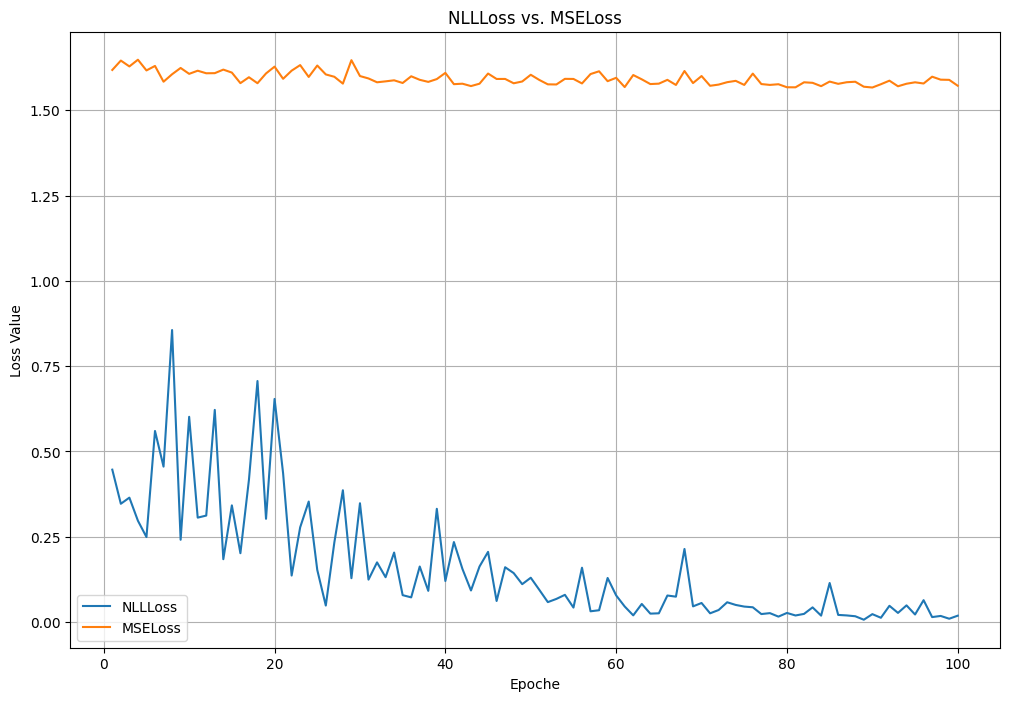

In [287]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_NLL, NLLLoss, label="NLLLoss")
plt.plot(epochs_MSE, MSELoss, label="MSELoss")
plt.xlabel("Epoche")
plt.ylabel("Loss Value")
plt.title("NLLLoss vs. MSELoss")
plt.legend()
plt.grid()
plt.show()

Conclusion on the comparison of the two loss functions:

The NLLLoss function shows clearly lower loss values which are getting really close to 0, while the MSELoss function is continuously at a loss value of just above 1.6. From this we can conclude that the NLLLoss function is better suited for this example than the MSELoss function.


### Reducing the Size of the NN:

Answer: Overitting can be seen if the accuracy of a model is really high for the test data but noticeably much smaller for the validation data. To change this, one can reduce the number of neurons in a neural network. <br>
Notice the smaller difference between the two accuracies of testing and validation data:

In [288]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)

In [304]:
# parameters
num_neurons_big = 512
learning_rate = 1e-2
loss_fn = nn.NLLLoss()
n_epochs = 100
dataset = train_loader
dataset_name = "train_loader(cifar2)"

time_start = time.time()
epochs_NLL = list(range(1, n_epochs+1))
NLLLoss = train_model(num_neurons_big, learning_rate, loss_fn, n_epochs, train_loader)
print_time(time_start, num_neurons_big, learning_rate, loss_fn, n_epochs, dataset_name)
print("Accuracy for 128 neurons (Training Data):", NLLaccuracy)

accuracy_val_big = accuracy_calculator(128, val_loader)
print("Accuracy for 128 neurons (Validation Data):", accuracy_val_big)


Epoch: 0, Loss: 0.542075
Epoch: 10, Loss: 0.579956
Epoch: 20, Loss: 0.504727
Epoch: 30, Loss: 0.198094
Epoch: 40, Loss: 0.104372
Epoch: 50, Loss: 0.093320
Epoch: 60, Loss: 0.035493
Epoch: 70, Loss: 0.022898
Epoch: 80, Loss: 0.019523
Epoch: 90, Loss: 0.008849
It took 1m and 18s to train the network with the following parameters:
	num_neurons = 512,
	learning_rate = 0.01,
	loss_fn = NLLLoss(),
	n_epochs = 100,
	dataset = train_loader(cifar2)
Accuracy for 128 neurons (Training Data): 0.9978
Accuracy for 128 neurons (Validation Data): 0.401


In [311]:
# parameters
num_neurons_small = 3


time_start = time.time()
epochs_NLL = list(range(1, n_epochs+1))
NLLLoss = train_model(num_neurons_small, learning_rate, loss_fn, n_epochs, train_loader)
print_time(time_start, num_neurons_small, learning_rate, loss_fn, n_epochs, dataset_name)
print("Accuracy for 10 neurons (Training Data):", NLLaccuracy)

accuracy_val_small = accuracy_calculator(num_neurons_small, val_loader)
print("Accuracy for 10 neurons (Validation Data):", accuracy_val_small)

Epoch: 0, Loss: 0.315581
Epoch: 10, Loss: 0.290139
Epoch: 20, Loss: 0.349636
Epoch: 30, Loss: 0.280632
Epoch: 40, Loss: 0.194855
Epoch: 50, Loss: 0.321276
Epoch: 60, Loss: 0.219427
Epoch: 70, Loss: 0.305992
Epoch: 80, Loss: 0.320221
Epoch: 90, Loss: 0.429030
Epoch: 99, Loss: 0.409162
It took 0m and 25s to train the network with the following parameters:
	num_neurons = 3,
	learning_rate = 0.01,
	loss_fn = NLLLoss(),
	n_epochs = 100,
	dataset = train_loader(cifar2)
Accuracy for 10 neurons (Training Data): 0.9978
Accuracy for 10 neurons (Validation Data): 0.5015
